<a href="https://colab.research.google.com/github/Urmi-Jana/Audio-Classifier/blob/main/Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bird Call -> waveform -> spectrogram -> neural net processing -> classification

1. Importing data

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/.kaggle'

In [ ]:
zip_path = '/content/drive/MyDrive/.kaggle/z-by-hp-unlocked-challenge-3-signal-processing.zip'
# !'{zip_path}'  #copying into current directory

!unzip -q '/content/drive/MyDrive/Kaggle/z-by-hp-unlocked-challenge-3-signal-processing.zip'

replace Forest Recordings/recording_00.mp3? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Install dependencies

In [ ]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_io as tfio

Setup the Dataloading function

In [ ]:
def load_data(filename):
  content = tf.io.read_file(filename) #loads encoded file
  wav_file, sample_rate = tf.audio.decode_wav(content, desired_channels = 1) #decodes to one channel
  # each value gives the amplitude per second (if that makes any sense)
  wav = tf.squeeze(wav_file, axis = 1) #remove the trailing axis
  sample_rate = tf.cast(sample_rate, dtype = tf.int64) # typecasting 
  wav_file = tfio.audio.resample(wav_file, rate_in = sample_rate, rate_out = 16000) #changing amplitude of audio signal
  return wav_file

In [ ]:
(tf.zeros([50000] - tf.shape(load_data('/content/Parsed_Capuchinbird_Clips/XC114131-0.wav')))) 

<tf.Tensor: shape=(10000, 49999), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
wave = "/content/Parsed_Capuchinbird_Clips/XC114131-0.wav"
non_wave = "/content/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav"

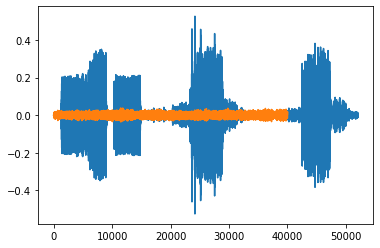

In [ ]:
wave = load_data(wave)
non_wave = load_data(non_wave)
plt.plot(non_wave)
plt.plot(wave)

plt.show()

Create **Dataset** using Tensorflow Dataset library

Define filepaths

In [ ]:
capuchin = os.path.join('Parsed_Capuchinbird_Clips')
not_capuchin = os.path.join('Parsed_Not_Capuchinbird_Clips')

In [ ]:
#gives a set of files as a string in a tf dataset format to preprocess
cap = tf.data.Dataset.list_files(capuchin + '/*.wav')
not_cap = tf.data.Dataset.list_files(not_capuchin + '/*.wav')

Label dataset and merge with files

In [ ]:
cap = tf.data.Dataset.zip((cap, tf.data.Dataset.from_tensor_slices(tf.ones(len(cap)))))
not_cap = tf.data.Dataset.zip((not_cap, tf.data.Dataset.from_tensor_slices(tf.zeros(len(not_cap)))))


In [ ]:
data = not_cap.concatenate(cap)

In [ ]:
data = data.shuffle(1000)

In [ ]:
data.as_numpy_iterator().next()

(b'Parsed_Capuchinbird_Clips/XC227468-1.wav', 1.0)

Calculate average of capuchin bird (so that we can slice the entire recording effectively to check)

calculate no. of complete wave cycles

In [ ]:
lengths = []
for file_name in os.listdir(capuchin):
  tensor_wave = load_data(os.path.join(capuchin, file_name))
  lengths.append(len(tensor_wave))

In [ ]:
# find the min and max length to effectively select how much of the clip we want to examine
tf.math.reduce_min(lengths), tf.math.reduce_max(lengths), 

(<tf.Tensor: shape=(), dtype=int32, numpy=32000>,
 <tf.Tensor: shape=(), dtype=int32, numpy=80000>)

In [ ]:
#average clip time =  average wave cycle duration/frequency (total wavecycles/cycles in one second)
tf.math.reduce_mean(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=3.38475>

Preprocessing function to convert to spectrogram

In [ ]:
def preprocess(file_path, label):
  wav = load_data(file_path)
  wav = wav[:50000] # between min and max values of lengths
  #if the clip is shorter, pad the remaining space with zeros
  wav = tf.squeeze((tf.pad(wav, [[0, 50000 - tf.shape(wav)[0]], [0,0]], mode='CONSTANT')))
  spectrogram = tf.signal.stft(wav, frame_length = 512, frame_step = 8)
  spectrogram = tf.abs(spectrogram) #take only positive values
  spectrogram = tf.expand_dims(spectrogram, axis = 2) 
  #expand the dimension so that the CV model takes it as channel input
  #produces channel length as 1. spectrogram gives shape(x,y, 1)
  return spectrogram, label

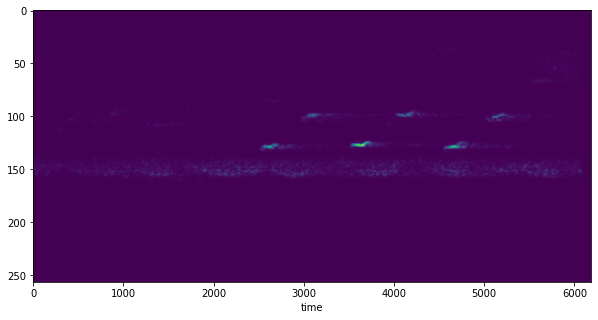

In [ ]:
file_path, label = data.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectrogram, label = preprocess(file_path, label)
plt.figure(figsize = (10, 5))
# plt.figure().set_figheight(20)

plt.imshow(tf.transpose(spectrogram)[0], aspect="auto")
plt.xlabel("time")
plt.show()


Creating Training and testing data

create data pipeline (MaCShuBaP)

In [ ]:
data = data.map(preprocess) #apply the function on all elements of the dataset and create new dataset
data = data.cache()
data = data.shuffle(10000)
data = data.batch(16) # separate into batches
data = data.prefetch(8) #allows later elements to be prepared while current is being processed

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training and testing datasets

In [ ]:
# we dont use train_test split as there are no separate dataset for labels
# as size of one batch is 51, we take 70% as training
train = data.take(35)
test = data.skip(35).take(16)

In [ ]:
samples.shape

(16, 6187, 257, 1)

Build model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape=(6187, 257, 1)))
model.add(Conv2D(16, (3,3), activation = 'relu'))
# model.add(Conv2D(8, (3,3), activation = 'relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

ResourceExhaustedError: ignored